# Environment

In [14]:
import fitbit

import pandas as pd
import numpy as np
from datetime import datetime
from fbprophet import Prophet

import matplotlib.pyplot as plt
%matplotlib inline
from pandas import Series
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_forecast_component

import math

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

from pylab import rcParams

# Visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# Acquisition

In [ ]:
chunks = fitbit.get_fitbit(files=['2018-04-26_through_2018-05-26.csv',
                           '2018-05-27_through_2018-06-26.csv',
                           '2018-06-27_through_2018-07-27.csv',
                           '2018-07-28_through_2018-08-26.csv',
                           '2018-08-27_through_2018-09-26.csv',
                           '2018-09-27_through_2018-10-27.csv',
                           '2018-10-28_through_2018-11-27.csv',
                           '2018-11-28_through_2018-12-28.csv'])

chunks = fitbit.clean_fitbit(chunks, cols=['Date', 'Calories Burned', 'Steps',
                            'Distance', 'Floors', 'Minutes Sedentary',
                            'Minutes Lightly Active', 'Minutes Fairly Active',
                            'Minutes Very Active', 'Activity Calories'])

# Preparation

In [ ]:
df = fitbit.prepare_fitbit(chunks, 8, 'Date')
df

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
Calories Burned           224 non-null object
Steps                     224 non-null object
Distance                  224 non-null float64
Floors                    224 non-null float64
Minutes Sedentary         224 non-null object
Minutes Lightly Active    224 non-null float64
Minutes Fairly Active     224 non-null float64
Minutes Very Active       224 non-null float64
Activity Calories         224 non-null object
dtypes: float64(5), object(4)
memory usage: 17.5+ KB


In [4]:
fitbit.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
Calories Burned,0,0.0,0,0.0,0,0.0
Steps,0,0.0,0,0.0,0,0.0
Distance,0,0.0,0,0.0,0,0.0
Floors,0,0.0,0,0.0,0,0.0
Minutes Sedentary,0,0.0,0,0.0,0,0.0
Minutes Lightly Active,0,0.0,0,0.0,0,0.0
Minutes Fairly Active,0,0.0,0,0.0,0,0.0
Minutes Very Active,0,0.0,0,0.0,0,0.0
Activity Calories,0,0.0,0,0.0,0,0.0


In [5]:
df = fitbit.convert_to_float(df, 'Calories Burned', 'Steps', 'Minutes Sedentary', 'Activity Calories')

In [6]:
fitbit.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
Calories Burned,0,0.000000,0,0.0,0,0.0
Steps,0,0.000000,0,0.0,0,0.0
Distance,0,0.000000,0,0.0,0,0.0
Floors,0,0.000000,0,0.0,0,0.0
Minutes Sedentary,71,31.696429,0,0.0,0,0.0
Minutes Lightly Active,0,0.000000,0,0.0,0,0.0
Minutes Fairly Active,0,0.000000,0,0.0,0,0.0
Minutes Very Active,0,0.000000,0,0.0,0,0.0
Activity Calories,0,0.000000,0,0.0,0,0.0


In [7]:
# Impute NaNs with mean values
df = df.fillna(df.mean())
fitbit.missing_values_col(df)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
Calories Burned,0,0.0,0,0.0,0,0.0
Steps,0,0.0,0,0.0,0,0.0
Distance,0,0.0,0,0.0,0,0.0
Floors,0,0.0,0,0.0,0,0.0
Minutes Sedentary,0,0.0,0,0.0,0,0.0
Minutes Lightly Active,0,0.0,0,0.0,0,0.0
Minutes Fairly Active,0,0.0,0,0.0,0,0.0
Minutes Very Active,0,0.0,0,0.0,0,0.0
Activity Calories,0,0.0,0,0.0,0,0.0


# Exploration

In [8]:
fitbit.summarize_data(df)

HEAD
            Calories Burned   Steps  Distance  Floors  Minutes Sedentary  \
Date                                                                       
2018-04-26           2635.0  2931.0      1.38     2.0             1347.0   
2018-04-27           3649.0  9971.0      4.70    19.0             1158.0   
2018-04-28           3379.0  3521.0      1.66     2.0              702.0   
2018-04-29           2851.0  1639.0      0.77     0.0              891.0   
2018-04-30           2825.0  1323.0      0.62     0.0              880.0   

            Minutes Lightly Active  Minutes Fairly Active  \
Date                                                        
2018-04-26                    93.0                    0.0   
2018-04-27                   219.0                   46.0   
2018-04-28                   155.0                   22.0   
2018-04-29                   122.0                    0.0   
2018-04-30                   104.0                    0.0   

            Minutes Very Active  A

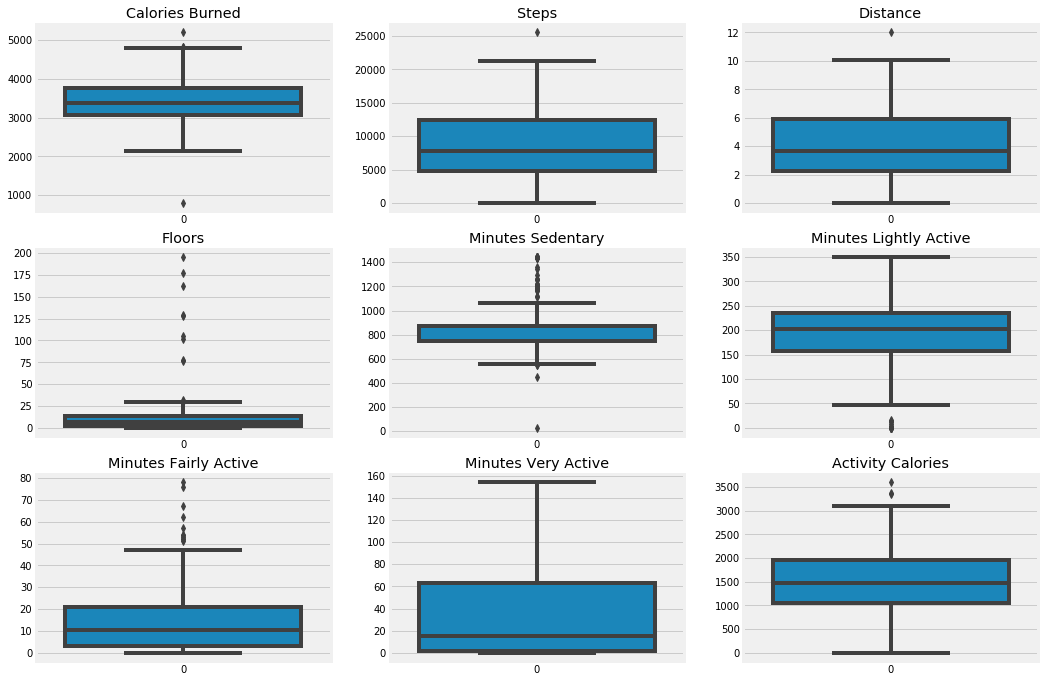

In [9]:
fitbit.plot_subs(df,
             df.select_dtypes(include='number').columns.values)

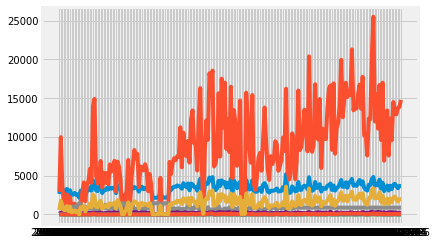

In [10]:
plt.plot(df)
plt.show()

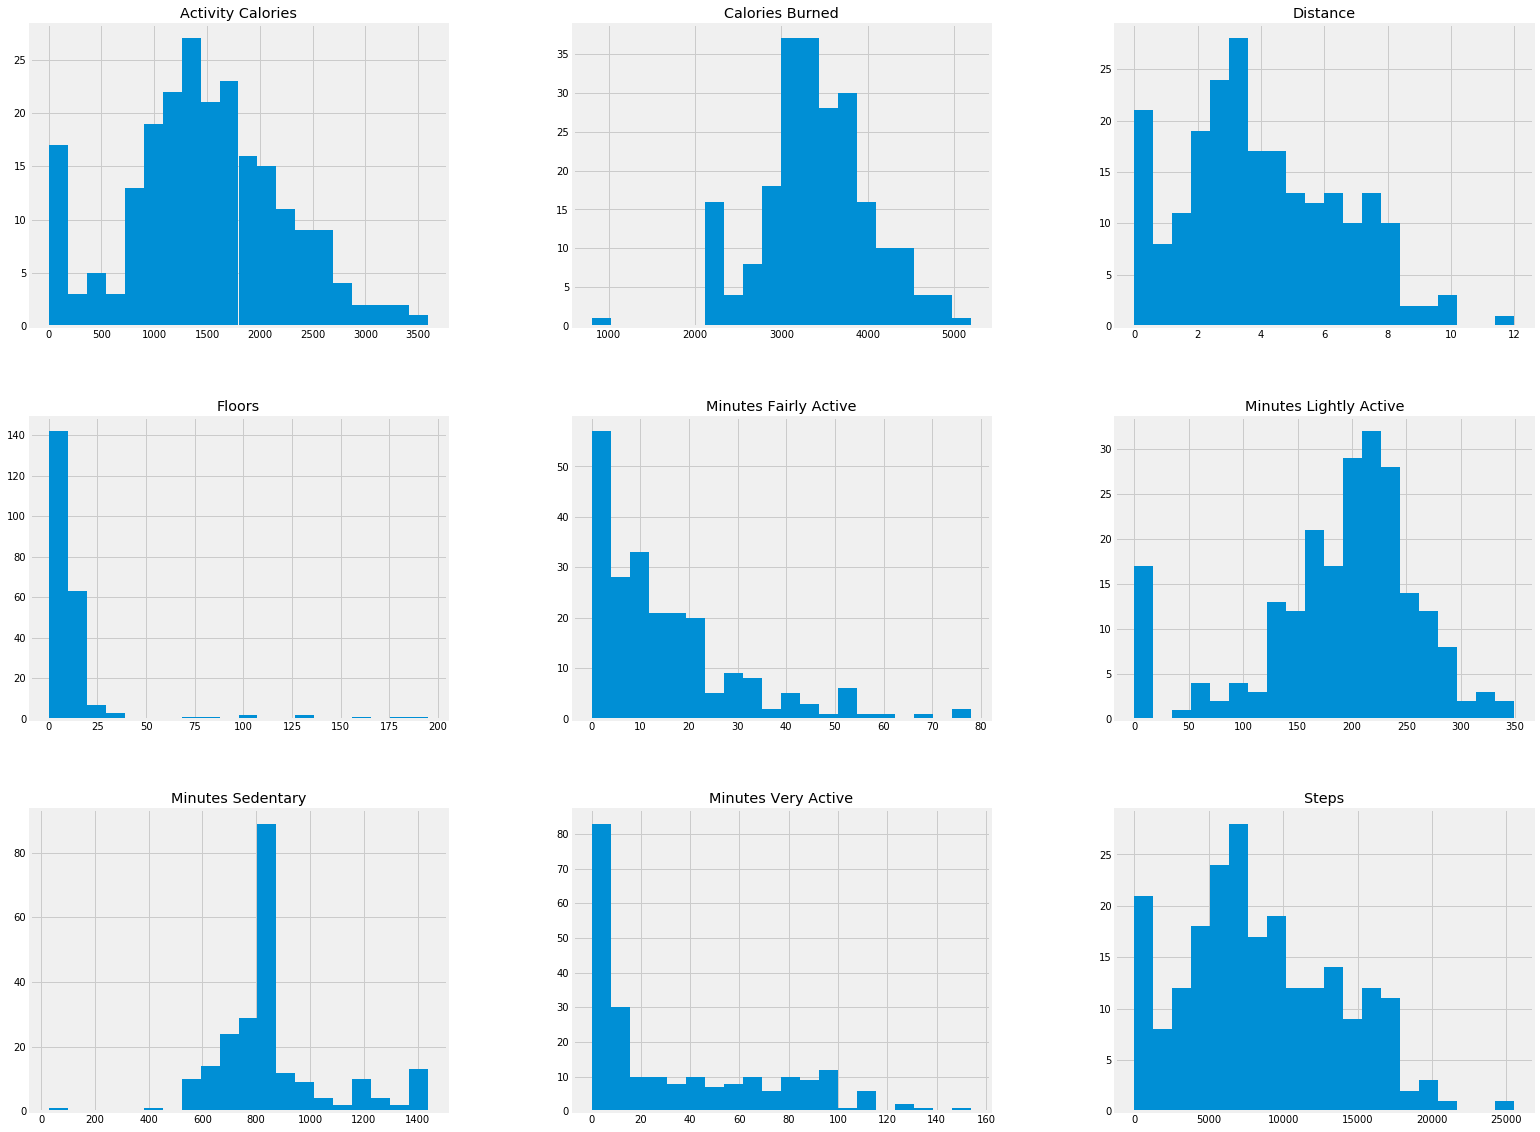

In [11]:
fitbit.plot_hist(df,20)

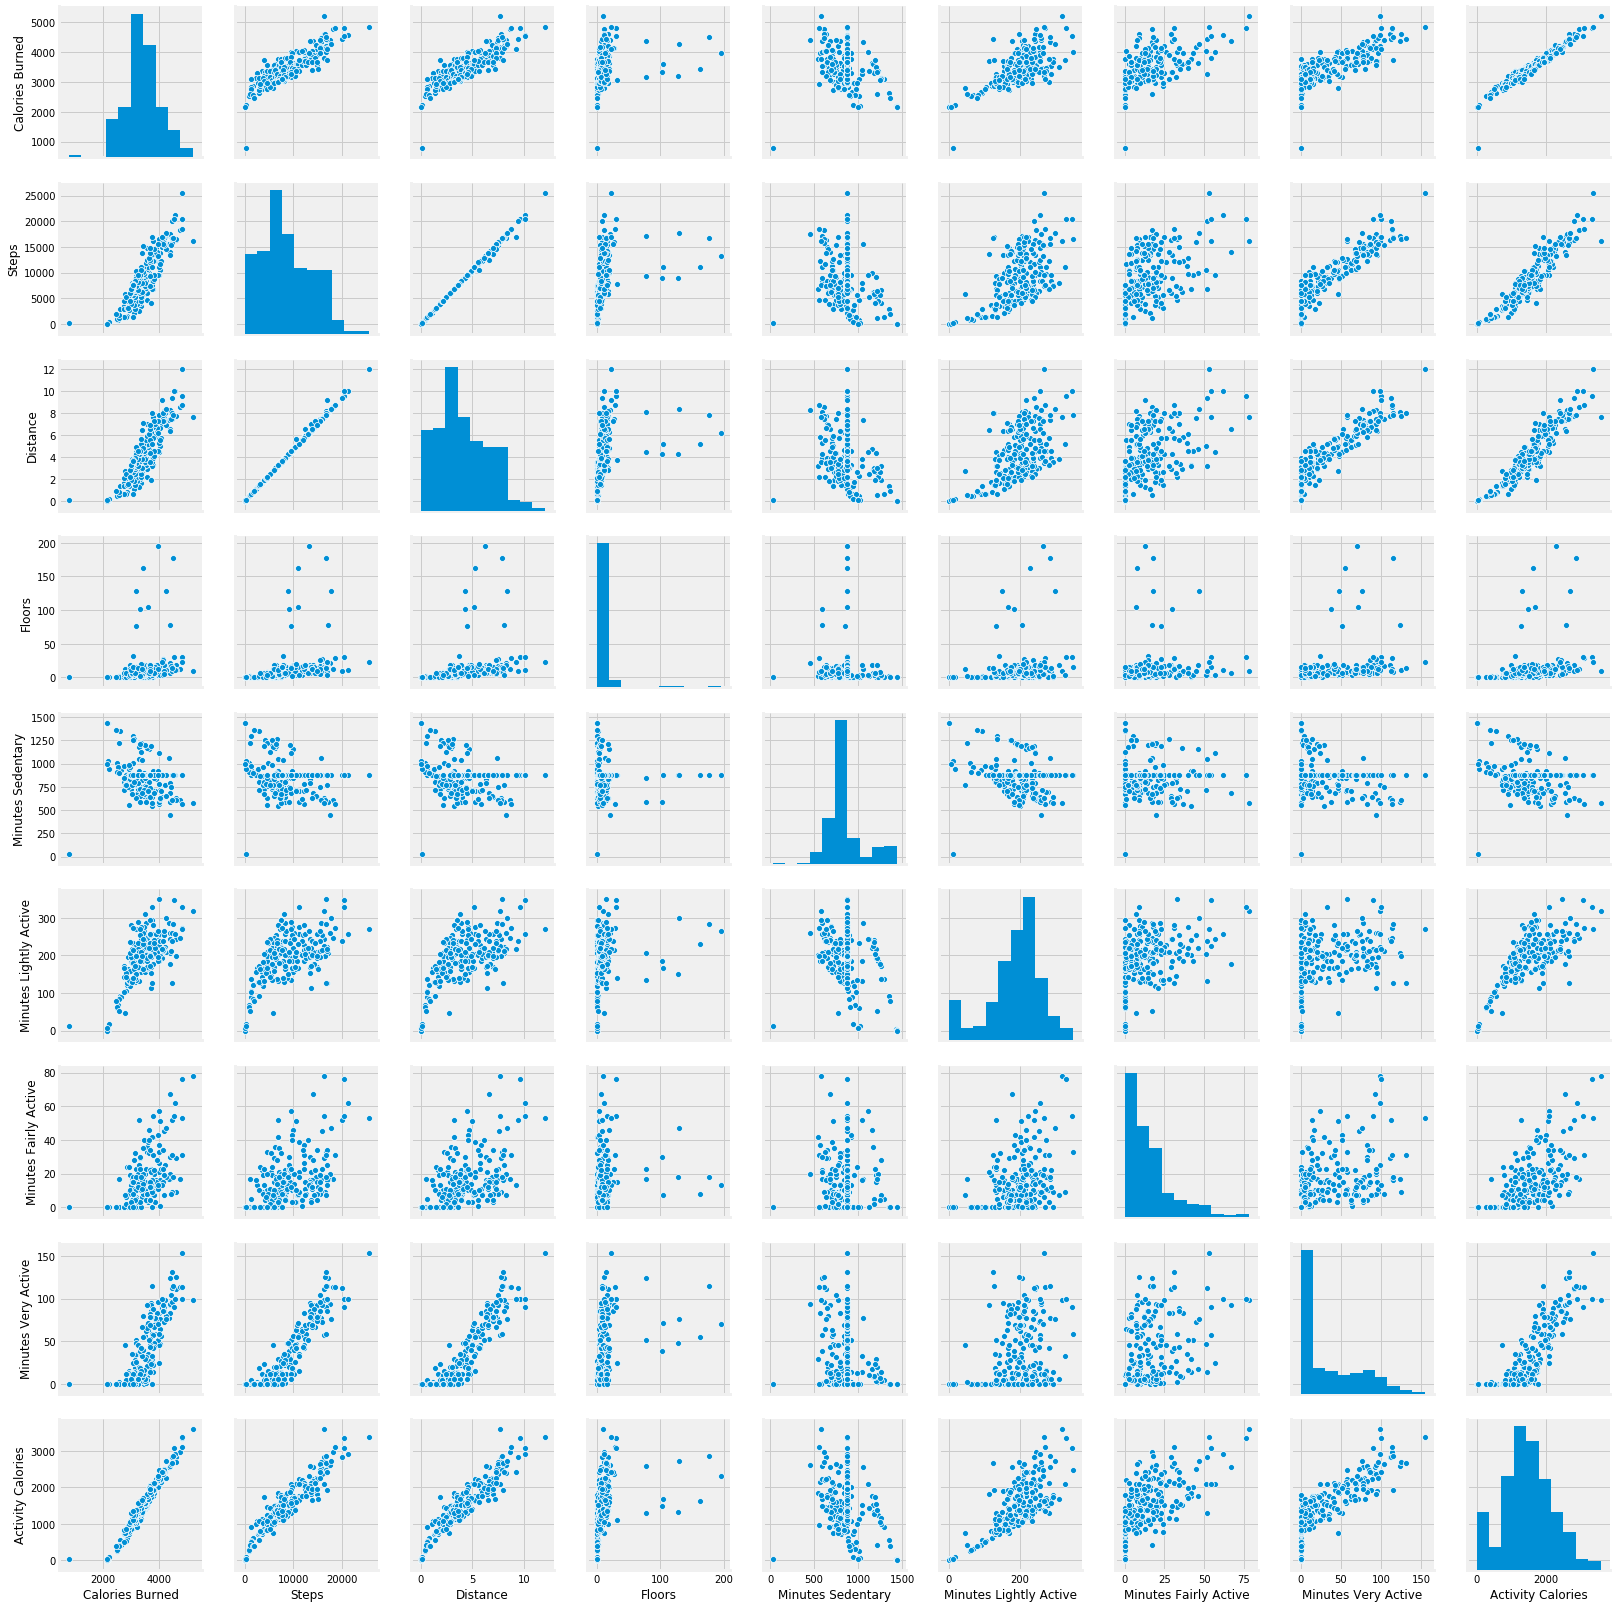

In [12]:
sns.pairplot(df)

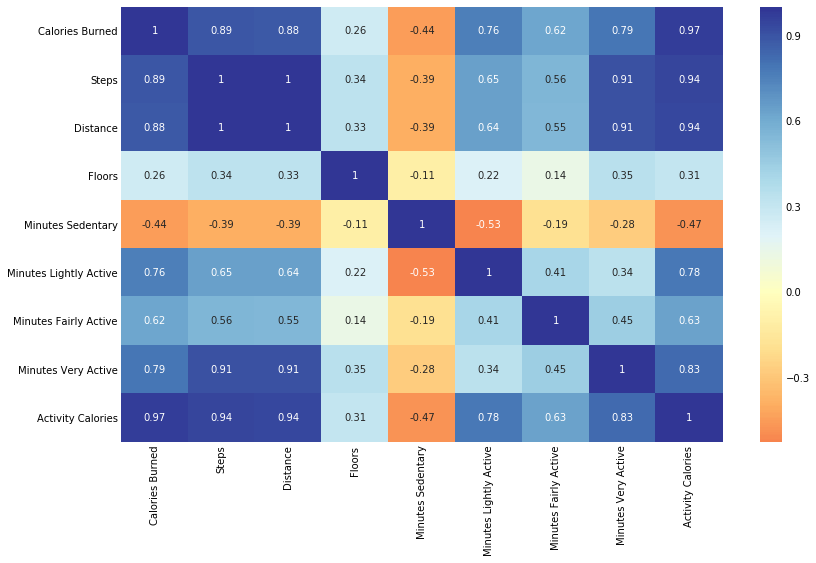

In [13]:
fitbit.plot_heat(df)

In [15]:
df = df.rename(columns={'Calories Burned': 'calories_burned'})

In [16]:
df.head()

,calories_burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
Date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [17]:
df.index = pd.to_datetime(df.index)

In [18]:
train = df[:'2018-10-31']
test = df['2018-11-01':]
print(train.nunique())
print(test.nunique())

calories_burned           171
Steps                     176
Distance                  158
Floors                     30
Minutes Sedentary         129
Minutes Lightly Active    118
Minutes Fairly Active      49
Minutes Very Active        75
Activity Calories         171
dtype: int64
calories_burned           36
Steps                     36
Distance                  35
Floors                    24
Minutes Sedentary          1
Minutes Lightly Active    30
Minutes Fairly Active     23
Minutes Very Active       29
Activity Calories         36
dtype: int64


In [19]:
cal_burned = train.resample('D').calories_burned.mean()

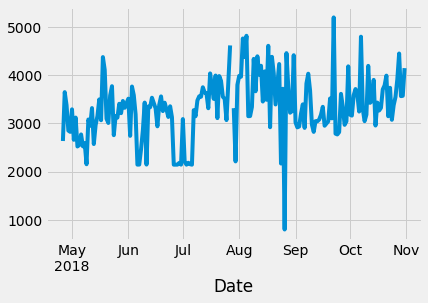

In [20]:
cal_burned.plot()

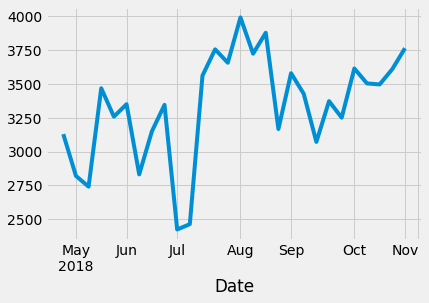

In [21]:
cal_burned.resample('W').mean().plot()

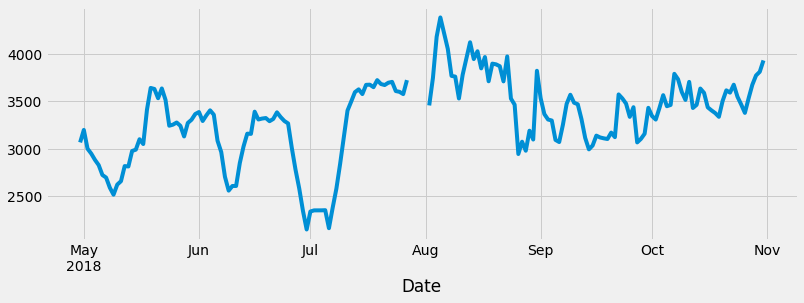

In [22]:
cal_burned.rolling(5).mean().plot(figsize=(12, 4))

In [23]:
cal_burned = cal_burned.fillna(cal_burned.mean())

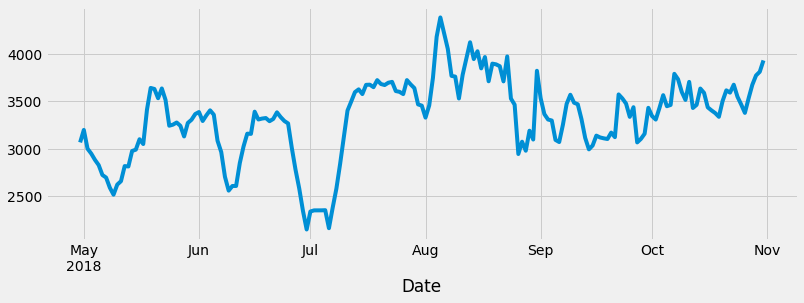

In [24]:
cal_burned.rolling(5).mean().plot(figsize=(12, 4))

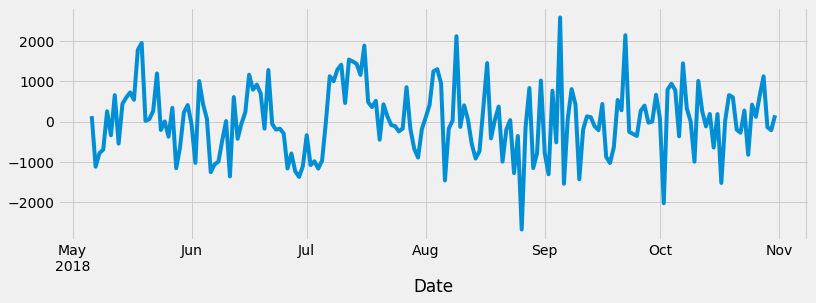

In [25]:
cal_burned.diff(periods=10).plot(figsize=(12, 4))

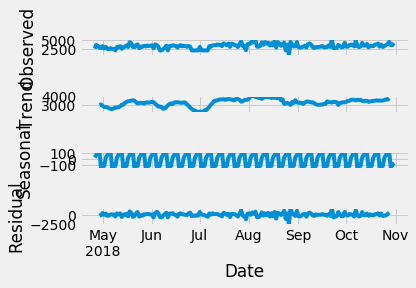

In [26]:
decomposition = sm.tsa.seasonal_decompose(cal_burned, model='additive')
fig = decomposition.plot()
plt.show()

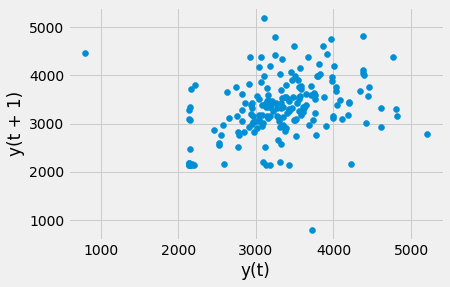

In [27]:
pd.plotting.lag_plot(cal_burned)

In [28]:
df_corr = pd.concat([cal_burned.shift(1), cal_burned], axis=1)
df_corr.columns = ['t-1','t+1']
result = df_corr.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.305219
t+1  0.305219  1.000000
